In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch

import numpy as np
from scipy.stats import multivariate_normal


In [3]:


# Define the GMM parameters
means = np.array([
    [0, 0, 0],
    [3, 3, 3],
    [0, -3, -3],
    [3, 0, 0]
])

covariances = np.array([
    3 * np.eye(3),
    1.5 * np.eye(3),
    3 * np.eye(3),
    4 * np.eye(3)
])

weights = np.array([0.1, 0.3, 0.5, 0.1])

# Function to compute the posterior P(Y=i | X=x)
def compute_posterior(x, means, covariances, weights):
    n_components = len(weights)
    n_features = x.shape[0]
    
    # Compute the likelihoods P(X=x | Y=i) for all i
    likelihoods = np.array([
        multivariate_normal.pdf(x, mean=means[i], cov=covariances[i])
        for i in range(n_components)
    ])
    
    # Compute the unnormalized posteriors P(X=x | Y=i) * P(Y=i)
    unnormalized_posteriors = weights * likelihoods
    
    # Normalize to get P(Y=i | X=x)
    posterior = unnormalized_posteriors / np.sum(unnormalized_posteriors)
    
    return posterior

# Example: Calculate the posterior for a given x
x = np.array([0,1,0.5])  # Example data point
posterior = compute_posterior(x, means, covariances, weights)
posterior


array([0.77234148, 0.01318957, 0.04289969, 0.17156926])

In [10]:

import pickle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

folder = "Results/gmm_Complementary"
corr = 0.2 
soft = torch.nn.Softmax(dim=1)

losses = ['Backward','Forward','Backward_conv','Forward_opt']
results = []
for los in losses:
    for rep in range(10):
        model_file = folder + f"/{los}_p_+{corr}p_-None_{rep}.pkl"
        with open(model_file, "rb") as f:
            model = pickle.load(f)
            f.close()
        model = model['overall_models']

        data_folder = f"Datasets/weak_datasets/gmm_Complementary_p{corr}"
        data_file = data_folder +  f"/Dataset_{rep}.pkl"
        f = open(data_file,"rb")
        Data,Weak = pickle.load(f)
        data = Data.test_dataset.data.to(device)

        
        yhat = soft(model(data)).cpu().detach().numpy()
        POS = np.array([list(compute_posterior(data[i,:].cpu().detach().numpy(),means, covariances, weights)) for i in range(data.shape[0])])
        AB = POS-yhat
        norms = np.diag(AB@AB.T)

        mean_norm = np.mean(norms)
        std_norm = np.std(norms)
        
        # Store values in the results list
        results.append({
            'cor':corr,
            "los": los,
            "rep": rep,
            "mean_norm": mean_norm,
            "std_norm": std_norm
        })
df_results = pd.DataFrame(results)
print(yhat)


c:\Users\danibacaicoa\vscode_projects\ForwardBackard_losses\.venv\Lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.

[[4.1696589e-02 9.4458294e-01 6.8271816e-05 1.3652268e-02]
 [2.2790058e-02 6.9175719e-04 8.9151853e-01 8.4999651e-02]
 [8.2641334e-04 3.9866330e-07 9.9778122e-01 1.3920193e-03]
 ...
 [1.0888046e-01 3.4535551e-04 8.7591290e-01 1.4861280e-02]
 [9.2627901e-01 8.8569596e-03 5.8385339e-02 6.4786887e-03]
 [4.0550005e-02 9.3582332e-01 1.3584940e-04 2.3490863e-02]]


In [11]:
df_results

,cor,los,rep,mean_norm,std_norm
0,0.2,Backward,0,0.060051,0.125432
1,0.2,Backward,1,0.052620,0.114664
2,0.2,Backward,2,0.029262,0.083052
3,0.2,Backward,3,0.047211,0.103418
4,0.2,Backward,4,0.047826,0.128846
5,0.2,Backward,5,0.036775,0.133138
6,0.2,Backward,6,0.041830,0.119890
7,0.2,Backward,7,0.032694,0.077465
8,0.2,Backward,8,0.033604,0.067471
9,0.2,Backward,9,0.037219,0.132133


C:\Users\danibacaicoa\AppData\Local\Temp\ipykernel_21904\3512343943.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels([' '])
C:\Users\danibacaicoa\AppData\Local\Temp\ipykernel_21904\3512343943.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels([' '])


['Backward', 'Forward', 'Backward_conv', 'Forward_opt']


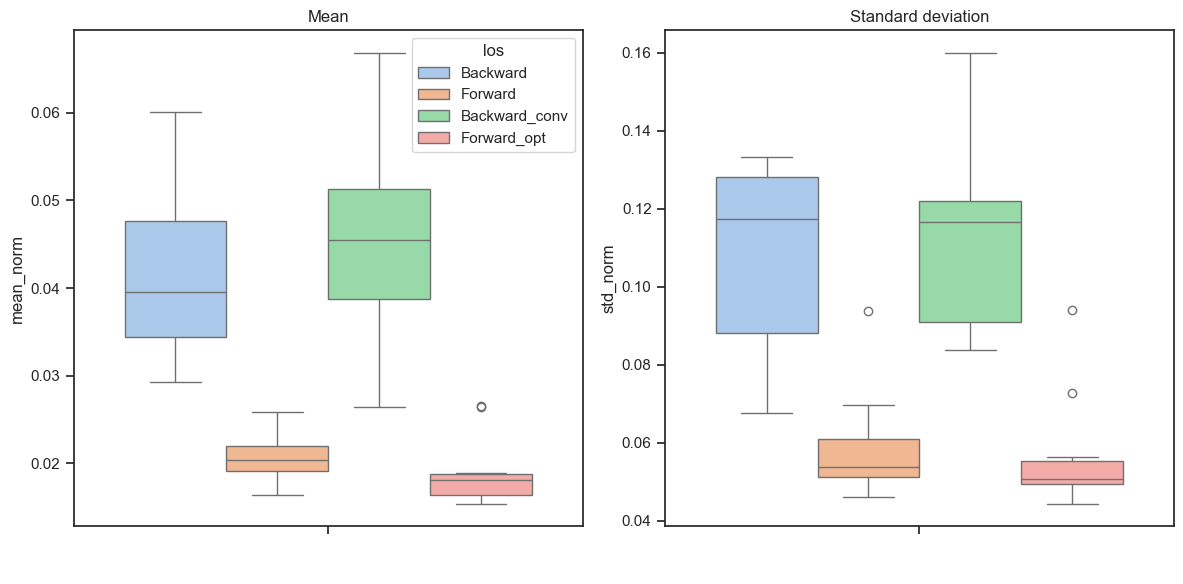

In [20]:


selected_loss_fns = ['Backward','Backward_conv', 'Forward', 'Forward_opt']


sns.set_theme(style="ticks", palette="pastel")
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

# Boxplot for train_acc
sns.boxplot(data=df_results,x = 'cor', y='mean_norm',hue='los', ax=axes[0])
axes[0].set_title('Mean')
axes[0].set_xlabel(' ')
#axes[0].set_ylabel('Train Accuracy')
axes[0].set_xticklabels([' '])
# Get the handles and labels from the current legend
handles, labels = axes[0].get_legend_handles_labels()
print(labels)
# Set the new legend labels
#new_labels = [r'Convex Backward',r'Backward',r'Forward (${\bf B}^\ast$)',r'Forward']  
#axes[0].legend(handles, new_labels, title='Loss Function')
#axes[0].legend(title='Loss', loc='lower left', labels=[r'Backward (${\bf B}^\ast$)',r'Backward',r'Forward (${\bf B}^\ast$)',r'Forward'])

# Boxplot for test_acc
sns.boxplot(data=df_results,x = 'cor', y='std_norm',hue='los', ax=axes[1])
axes[1].set_title('Standard deviation')
#axes[1].set_xlabel(r'$\rho=(\rho_{-1},\rho_{+1})$')
#axes[1].set_ylabel('Test Accuracy')
axes[1].set_xlabel(' ')
#axes[0].set_ylabel('Train Accuracy')
axes[1].set_xticklabels([' '])
#axes[1].set_xticklabels(['(0.2,0.2)','(0.3,0.1)','(0.4,0.4)'])
axes[1].legend().remove()


# Adjust layout
plt.tight_layout()
plt.show()

# GMM
## Partial labels

In [25]:

import pickle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

folder = "Results/gmm_pll"
corr = [0.3,0.5,0.8] 
soft = torch.nn.Softmax(dim=1)

losses = ['Backward','Forward','Backward_conv','Forward_opt','Backward_opt_conv','EM','LBL']
results = []
for e, cor in enumerate(corr):
    for los in losses:
        for rep in range(10):
            model_file = folder + f"/{los}_p_+{cor}p_-None_{rep}.pkl"
            with open(model_file, "rb") as f:
                model = pickle.load(f)
                f.close()
            model = model['overall_models']

            data_folder = f"Datasets/weak_datasets/gmm_pll_p{cor}"
            data_file = data_folder +  f"/Dataset_{rep}.pkl"
            f = open(data_file,"rb")
            Data,Weak = pickle.load(f)
            data = Data.test_dataset.data.to(device)

            
            yhat = soft(model(data)).cpu().detach().numpy()
            POS = np.array([list(compute_posterior(data[i,:].cpu().detach().numpy(),means, covariances, weights)) for i in range(data.shape[0])])
            AB = POS-yhat
            norms = np.diag(AB@AB.T)

            mean_norm = np.mean(norms)
            std_norm = np.std(norms)
            
            # Store values in the results list
            results.append({
                "cor": cor,
                "los": los,
                "rep": rep,
                "mean_norm": mean_norm,
                "std_norm": std_norm
            })
df_results = pd.DataFrame(results)
print(yhat)


c:\Users\danibacaicoa\vscode_projects\ForwardBackard_losses\.venv\Lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.

[[0.20846629 0.24646877 0.29375276 0.25131217]
 [0.2444012  0.2255277  0.31222492 0.21784618]
 [0.24688512 0.31394383 0.2185783  0.22059272]
 ...
 [0.23710288 0.27758488 0.2526789  0.23263334]
 [0.23608486 0.29669634 0.23806599 0.22915286]
 [0.23098537 0.21737556 0.3237802  0.22785887]]


In [26]:
df_results

,cor,los,rep,mean_norm,std_norm
0,0.3,Backward,0,0.010229,0.026084
1,0.3,Backward,1,0.010841,0.045649
2,0.3,Backward,2,0.011626,0.053054
3,0.3,Backward,3,0.010354,0.035841
4,0.3,Backward,4,0.008677,0.038447
...,...,...,...,...,...
205,0.8,LBL,5,0.449701,0.136637
206,0.8,LBL,6,0.458234,0.144563
207,0.8,LBL,7,0.452393,0.137932
208,0.8,LBL,8,0.454455,0.146056


C:\Users\danibacaicoa\AppData\Local\Temp\ipykernel_21904\465935550.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels([' '])
C:\Users\danibacaicoa\AppData\Local\Temp\ipykernel_21904\465935550.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels([' '])


['Backward', 'Forward', 'Backward_conv', 'Forward_opt', 'Backward_opt_conv']


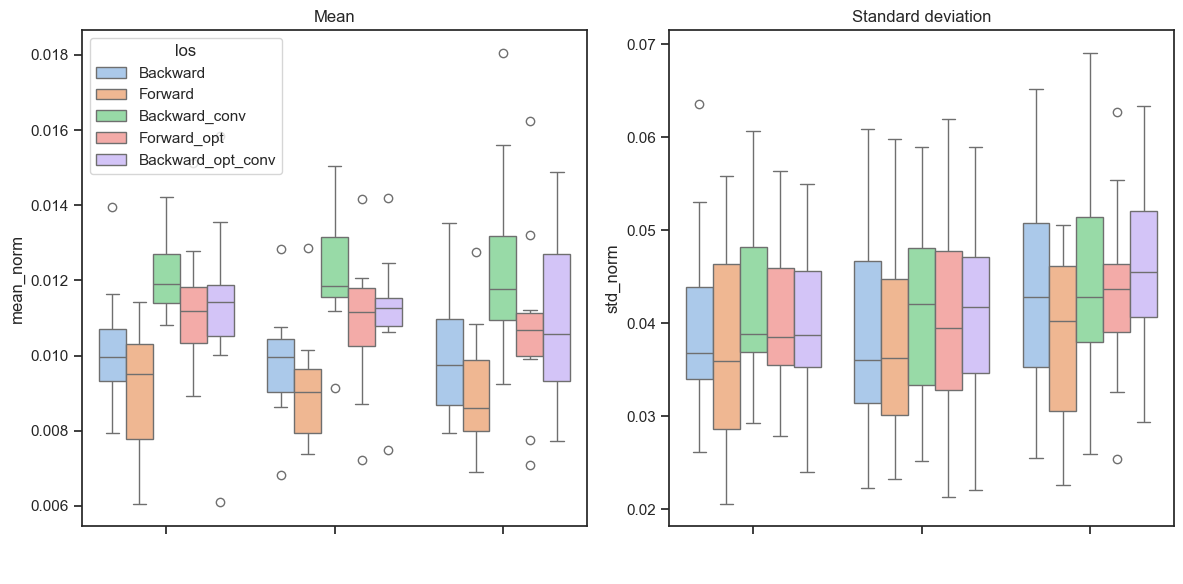

In [29]:


#selected_loss_fns = ['Backward','Backward_conv', 'Forward', 'Forward_opt']
loss_fn_filter = ['Backward', 'Backward_conv', 'Backward_opt_conv', 'Forward', 'Forward_opt']

df_results = df_results[df_results['los'].isin(loss_fn_filter)]


sns.set_theme(style="ticks", palette="pastel")
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

# Boxplot for train_acc
sns.boxplot(data=df_results,x = 'cor', y='mean_norm',hue='los', ax=axes[0])
axes[0].set_title('Mean')
axes[0].set_xlabel(' ')
#axes[0].set_ylabel('Train Accuracy')
axes[0].set_xticklabels([' '])
# Get the handles and labels from the current legend
handles, labels = axes[0].get_legend_handles_labels()
print(labels)
# Set the new legend labels
#new_labels = [r'Convex Backward',r'Backward',r'Forward (${\bf B}^\ast$)',r'Forward']  
#axes[0].legend(handles, new_labels, title='Loss Function')
#axes[0].legend(title='Loss', loc='lower left', labels=[r'Backward (${\bf B}^\ast$)',r'Backward',r'Forward (${\bf B}^\ast$)',r'Forward'])

# Boxplot for test_acc
sns.boxplot(data=df_results,x = 'cor', y='std_norm',hue='los', ax=axes[1])
axes[1].set_title('Standard deviation')
#axes[1].set_xlabel(r'$\rho=(\rho_{-1},\rho_{+1})$')
#axes[1].set_ylabel('Test Accuracy')
axes[1].set_xlabel(' ')
#axes[0].set_ylabel('Train Accuracy')
axes[1].set_xticklabels([' '])
#axes[1].set_xticklabels(['(0.2,0.2)','(0.3,0.1)','(0.4,0.4)'])
axes[1].legend().remove()


# Adjust layout
plt.tight_layout()
plt.show()


In [9]:
df_results

NameError: name 'df_results' is not defined